### Consigna

- Utilizar otro dataset y poner en práctica la generación de secuencias con las estrategias presentadas.

In [38]:
import random
import io
import os
import pickle
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [39]:
# Descargar la carpeta de dataset
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [40]:
# Posibles bandas
os.listdir("./songs_dataset/")

['bjork.txt',
 'nirvana.txt',
 'nickelback.txt',
 'lady-gaga.txt',
 'missy-elliott.txt',
 'cake.txt',
 'bruno-mars.txt',
 'janisjoplin.txt',
 'prince.txt',
 'r-kelly.txt',
 'lin-manuel-miranda.txt',
 'Kanye_West.txt',
 'eminem.txt',
 'bruce-springsteen.txt',
 'dr-seuss.txt',
 'adele.txt',
 'ludacris.txt',
 'bob-dylan.txt',
 'lil-wayne.txt',
 'beatles.txt',
 'britney-spears.txt',
 'rihanna.txt',
 'leonard-cohen.txt',
 'notorious_big.txt',
 'radiohead.txt',
 'amy-winehouse.txt',
 'drake.txt',
 'lorde.txt',
 'bob-marley.txt',
 'paul-simon.txt',
 'blink-182.txt',
 'nicki-minaj.txt',
 'bieber.txt',
 'Lil_Wayne.txt',
 'nursery_rhymes.txt',
 'patti-smith.txt',
 'johnny-cash.txt',
 'disney.txt',
 'dolly-parton.txt',
 'kanye-west.txt',
 'jimi-hendrix.txt',
 'al-green.txt',
 'dj-khaled.txt',
 'joni-mitchell.txt',
 'kanye.txt',
 'notorious-big.txt',
 'michael-jackson.txt',
 'dickinson.txt',
 'alicia-keys.txt']

In [41]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/michael-jackson.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-2845004978.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/michael-jackson.txt', sep='/n', header=None)


,0
0,[Spoken Intro:]
1,You ever want something
2,that you know you shouldn't have
3,"The more you know you shouldn't have it,"
4,The more you want it


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [42]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 9484


### Elegir el tamaño del contexto

In [43]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [44]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['[Spoken Intro:]',
 'You ever want something',
 "that you know you shouldn't have",
 "The more you know you shouldn't have it,",
 'The more you want it',
 'And then one day you get it,',
 "It's so good too",
 "But it's just like my girl",
 "When she's around me",
 'I just feel so good, so good',
 'But right now I just feel cold, so cold',
 'Right down to my bones',
 "'Cause ooh...",
 "Ain't no sunshine when she's gone",
 "It's not warm when she's away",
 "Ain't no sunshine when she's gone",
 "And she's always gone too long",
 'Anytime she goes away',
 "Wonder this time where she's gone",
 "Wonder if she's gone to stay",
 "Ain't no sunshine when she's gone",
 "And this house just ain't no home",
 'Anytime she goes away',
 'I know, I know, I know, I know,',
 'I know, know, know, know, know,',
 'I know, I know,',
 'Hey I ought to leave',
 'I ought to leave her alone',
 "Ain't no sunshine when she's gone",
 "Ain't no sunshine when she's gone",
 'Only darkness every day',
 "Ain't no sunshi

In [45]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [46]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([5.950e+02, 6.180e+02, 1.179e+03, 1.605e+03, 1.509e+03, 1.404e+03,
        9.170e+02, 6.920e+02, 3.830e+02, 2.540e+02, 1.570e+02, 6.200e+01,
        6.300e+01, 2.300e+01, 1.000e+01, 7.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

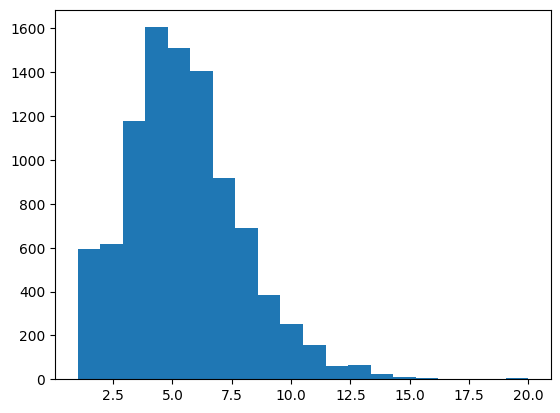

In [47]:
# podemos ver su distribución
plt.hist(length_sentences, bins=20)

In [48]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 8


###  Tokenizar

In [49]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)
tokenized_sentences

[[680, 1001],
 [1, 169, 90, 294],
 [16, 1, 24, 1, 1002, 74],
 [2, 190, 1, 24, 1, 1002, 74, 7],
 [2, 190, 1, 90, 7],
 [6, 99, 70, 91, 1, 29, 7],
 [39, 23, 150, 53],
 [43, 39, 18, 41, 9, 32],
 [47, 86, 81, 4],
 [3, 18, 79, 23, 150, 23, 150],
 [43, 76, 57, 3, 18, 79, 192, 23, 192],
 [76, 85, 5, 9, 1412],
 [94, 139],
 [71, 25, 450, 47, 86, 131],
 [39, 80, 426, 47, 86, 77],
 [71, 25, 450, 47, 86, 131],
 [6, 86, 136, 131, 53, 221],
 [892, 33, 385, 77],
 [588, 49, 62, 142, 86, 131],
 [588, 44, 86, 131, 5, 151],
 [71, 25, 450, 47, 86, 131],
 [6, 49, 893, 18, 71, 25, 270],
 [892, 33, 385, 77],
 [3, 24, 3, 24, 3, 24, 3, 24],
 [3, 24, 24, 24, 24, 24],
 [3, 24, 3, 24],
 [201, 3, 1154, 5, 118],
 [3, 1154, 5, 118, 60, 97],
 [71, 25, 450, 47, 86, 131],
 [71, 25, 450, 47, 86, 131],
 [162, 797, 112, 91],
 [71, 25, 450, 47, 86, 131],
 [6, 49, 893, 18, 71, 25, 270],
 [892, 33, 385, 77],
 [42, 7, 19, 3, 894, 77, 53, 221],
 [129, 3, 118, 12, 183, 47, 3, 87, 131],
 [39, 80, 9, 177, 728, 5, 29, 109],
 [43, 4

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [50]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [51]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size + 1):
    extra = len(sent) - (max_context_size + 1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i + max_context_size + 1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)
len(tok_sent)

8645

In [52]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i + 2] for i in range(len(sent) - 1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size + 1, padding='pre'))

In [53]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)
train_seqs.shape

(39554, 9)

In [54]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [55]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'the',
 3: 'i',
 4: 'me',
 5: 'to',
 6: 'and',
 7: 'it',
 8: 'a',
 9: 'my',
 10: 'in',
 11: 'love',
 12: 'your',
 13: "don't",
 14: 'is',
 15: 'of',
 16: 'that',
 17: 'on',
 18: 'just',
 19: 'be',
 20: 'for',
 21: 'all',
 22: 'baby',
 23: 'so',
 24: 'know',
 25: 'no',
 26: "you're",
 27: "i'm",
 28: 'do',
 29: 'get',
 30: 'got',
 31: 'what',
 32: 'girl',
 33: 'she',
 34: 'are',
 35: 'with',
 36: 'yeah',
 37: 'bad',
 38: 'make',
 39: "it's",
 40: 'we',
 41: 'like',
 42: 'can',
 43: 'but',
 44: 'if',
 45: 'really',
 46: 'about',
 47: 'when',
 48: "can't",
 49: 'this',
 50: 'let',
 51: 'oh',
 52: 'wanna',
 53: 'too',
 54: 'he',
 55: 'world',
 56: 'stop',
 57: 'now',
 58: 'take',
 59: 'there',
 60: 'her',
 61: 'give',
 62: 'time',
 63: 'go',
 64: 'see',
 65: 'come',
 66: 'keep',
 67: 'how',
 68: 'will',
 69: 'why',
 70: 'one',
 71: "ain't",
 72: 'way',
 73: 'they',
 74: 'have',
 75: 'life',
 76: 'right',
 77: 'away',
 78: 'chorus',
 79: 'feel',
 80: 'not',
 81: 'around',
 82

In [56]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3273

In [57]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'the': 2, 'i': 3, 'me': 4, 'to': 5, 'and': 6, 'it': 7, 'a': 8, 'my': 9, 'in': 10, 'love': 11, 'your': 12, "don't": 13, 'is': 14, 'of': 15, 'that': 16, 'on': 17, 'just': 18, 'be': 19, 'for': 20, 'all': 21, 'baby': 22, 'so': 23, 'know': 24, 'no': 25, "you're": 26, "i'm": 27, 'do': 28, 'get': 29, 'got': 30, 'what': 31, 'girl': 32, 'she': 33, 'are': 34, 'with': 35, 'yeah': 36, 'bad': 37, 'make': 38, "it's": 39, 'we': 40, 'like': 41, 'can': 42, 'but': 43, 'if': 44, 'really': 45, 'about': 46, 'when': 47, "can't": 48, 'this': 49, 'let': 50, 'oh': 51, 'wanna': 52, 'too': 53, 'he': 54, 'world': 55, 'stop': 56, 'now': 57, 'take': 58, 'there': 59, 'her': 60, 'give': 61, 'time': 62, 'go': 63, 'see': 64, 'come': 65, 'keep': 66, 'how': 67, 'will': 68, 'why': 69, 'one': 70, "ain't": 71, 'way': 72, 'they': 73, 'have': 74, 'life': 75, 'right': 76, 'away': 77, 'chorus': 78, 'feel': 79, 'not': 80, 'around': 81, 'gonna': 82, 'say': 83, 'up': 84, 'down': 85, "she's": 86, 'was': 87, 'out': 88, 't

In [58]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'intro': 4, 'spoken': 8, 'want': 112, 'something': 24, 'you': 2166, 'ever': 46, "shouldn't": 4, 'know': 239, 'that': 401, 'have': 136, 'it': 826, 'more': 39, 'the': 1560, 'then': 98, 'one': 137, 'and': 909, 'day': 112, 'get': 262, "it's": 214, 'good': 50, 'so': 302, 'too': 152, 'just': 395, 'my': 695, 'but': 195, 'like': 215, 'girl': 237, 'around': 109, 'when': 179, 'me': 1140, "she's": 119, 'i': 1219, 'feel': 128, 'now': 160, 'cold': 38, 'right': 136, 'down': 125, 'bones': 2, 'to': 1032, "'cause": 110, 'ooh': 56, 'sunshine': 14, 'gone': 64, 'no': 251, "ain't": 139, 'warm': 15, 'not': 131, 'away': 134, 'always': 61, 'long': 33, 'anytime': 5, 'she': 236, 'goes': 17, 'where': 58, 'this': 181, 'wonder': 10, 'time': 163, 'if': 192, 'stay': 51, 'home': 25, 'house': 5, 'leave': 72, 'ought': 3, 'hey': 23, 'alone': 105, 'her': 154, 'only': 46, 'darkness': 6, 'every': 76, 'be': 371, 'can': 199, 'stayed': 5, 'was': 109, 'your': 473, 'did': 62, 'mind': 43, 'back': 77, 

In [59]:
# Process the validation data similarly to the training data
tok_sent_val = []

for sent in tokenized_sentences_val:
  if len(sent) > (max_context_size + 1):
    extra = len(sent) - (max_context_size + 1) + 1
    for i in range(extra):
      tok_sent_val.append(sent[i:i + max_context_size + 1])
  else:
    tok_sent_val.append(sent)

tok_sent_augm_val = []

for sent in tok_sent_val:
  subseq = [sent[:i + 2] for i in range(len(sent) - 1)]
  tok_sent_augm_val.append(pad_sequences(subseq, maxlen=max_context_size + 1, padding='pre'))

# Concatenate validation sequences
val_seqs = np.concatenate(tok_sent_augm_val, axis=0)

# Separate features and targets for validation data
X_val = val_seqs[:,:-1]
y_val = val_seqs[:,-1]


### Definir el modelo

In [60]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size + 1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size + 1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 8, 5)           │        16,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3274)           │       108,042 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,436 (693.11 KB)

 Trainable params: 177,436 (693.11 KB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [61]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

### Entrenamiento

In [62]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val)], validation_data=(X_val, y_val), batch_size=64)

Epoch 1/20
616/619 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0482 - loss: 6.5188
 mean perplexity: 4795.2822265625 

619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0482 - loss: 6.5168 - val_accuracy: 0.0492 - val_loss: 6.1855
Epoch 2/20
617/619 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0509 - loss: 5.9956
 mean perplexity: 100537.21875 

619/619 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0509 - loss: 5.9956 - val_accuracy: 0.0492 - val_loss: 6.1356
Epoch 3/20
617/619 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0503 - loss: 5.8463
 mean perplexity: 2307674.0 

619/619 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.0503 - loss: 5.8462 - val_accuracy: 0.0553 - val_loss: 5.9895
Epoch 4/20
615/619 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0553 - loss: 5.6401
 mean perplexity: 345508.84375 

619/619 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0553 - loss: 5.6399 - val_accuracy: 0.0538 - val_loss: 5.8936
Epoch 5/20
613/619 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

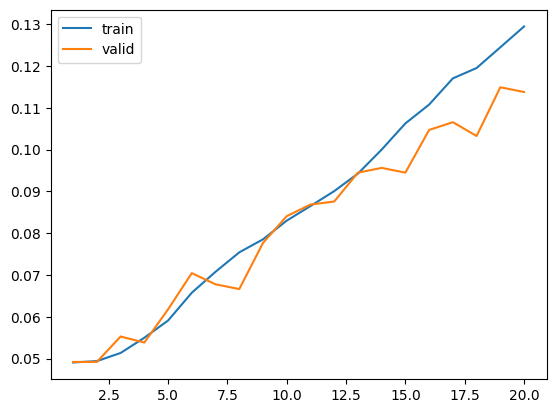

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()


### Predicción de próxima palabra

In [64]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [65]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por el modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e89f67e17afe471f65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e89f67e17afe471f65.gradio.live


### Generación de secuencias

In [66]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por el modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [67]:
input_text='She\'s just a girl'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


"She's just a girl is a"

###  Beam search y muestreo aleatorio

In [68]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [69]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [70]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="But terror takes the")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [71]:
# veamos las salidas
decode(salidas[0])

['but terror takes the price of me you are call']

### Conclusión

Se ensayaron estrategias de generación de secuencias como la predicción de la siguiente palabra y la búsqueda beam search para generar texto coherente a partir de una semilla inicial. Aunque las secuencias generadas no son incoherentes en el contexto de canciones de Michael Jackson, si es de reconocer que se observaron pocas oportunidades en que la predicción sea similar al verso real de la canción.

Como próximos pasos, se podría considerar la experimentación con diferentes arquitecturas de modelos, la optimización de hiperparámetros y la utilización de datasets más extensos. Además, se podrían implementar otras estrategias de generación de secuencias avanzadas para mejorar la diversidad y coherencia del texto generado.